# ノノグラムゲーム

ノノグラムは論理的なパズルゲームで、ルールは簡単ですが、解く過程は挑戦的です。ゲームボードは正方形のグリッドで、各セルは最終的に黒または白に塗りつぶされる必要があります。グリッドの各行の左側にある数字は、その行における隣接する黒いセルの長さを示し、各列の下にある数字はその列における隣接する黒いセルの長さを示しています。ゲームの目的は、すべての黒いセルを特定することです。次のグラフは簡単なノノグラムゲームの解を示しています。

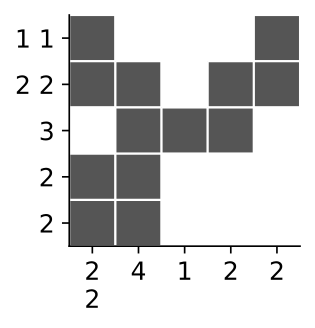

各セルの状態はブール変数で表すことができ、これらのブール変数に制約条件を追加するためには、まず行や列に対応するブール式を見つける必要があります。

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import itertools

## 各行の数字に対応する解

以下の `paint_numbers()` は再帰アルゴリズムを使用して、1行の数字をその対応するセルのすべての解に変換します。引数として数字のリスト `numbers` と、塗りつぶす必要のあるセルの数 `count` を取ります。再帰の終了条件は2つです：

❶ `numbers` に対応するセルの数が塗りつぶすべきセル数 `count` より多い場合、解は存在しません。例えば `numbers` が `[2, 1, 5]` の場合、少なくとも10個のセルが必要です。

❷ `numbers` に残っている数字が1つだけの場合、その数字が `count` 長さのセル内で可能なすべての解を列挙します。

上記の終了条件が満たされない場合、`paint_numbers()` を再帰的に呼び出し、以下の2つの分岐があります：

  - ❸ `numbers` の最初の数字をセルに塗りつぶし、その後 `numbers[1:]` を再帰的に塗りつぶします。このとき、残りの塗りつぶすべきセル数は `count - numbers[0] - 1` となります。
  - ❹ 1つのセルをスキップし、残りの `count - 1` セルに `numbers` を塗りつぶします。

In [3]:
def paint_numbers(numbers, count):
    if sum(numbers) + len(numbers) - 1 > count: #❶
        return
    elif len(numbers) == 1: #❷
        for i in range(0, count - numbers[0] + 1):
            yield [-1] * i + [1] * numbers[0] + [-1] * (count - i - numbers[0])
    else:
        for res in paint_numbers(numbers[1:], count - numbers[0] - 1): #❸
            yield [1] * numbers[0] + [-1] + res
        for res in paint_numbers(numbers, count - 1): #❹
            yield [-1] + res

以下は、`[2, 1, 5]` を12個のセルに塗りつぶすときのすべての解を計算した結果です。結果の中で、1は塗りつぶされたセルを、-1は空白のセルを示します。結果を見やすくするために、-1は0に変換して表示します。

In [4]:
for line in paint_numbers([2, 1, 5], 12):
    print([int(x > 0) for x in line])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]
[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


## DNFからCNFへの変換

`paint_numbers()` は、一行または一列のマス目におけるすべての解を求めることが可能です。これらの解は論理和（OR）で結ばれており、それぞれの解の内部では論理積（AND）が成り立っております。このようなブール式は析取標準形（DNF, Disjunctive Normal Form）と呼ばれます。一方で、pysat は合取標準形（CNF, Conjunctive Normal Form）のブール式のみを解くことが可能であるため、DNFをCNFに変換する必要がございます。この変換は一般的に非常に困難ですが、本書では新たなブール変数を導入することで変換を行う方法をご紹介いたします。

たとえば、次のDNF式は、ブール変数 $A$、$B$、$C$ のうちちょうど1つが偽であることを表しております：

$$
(\neg A \wedge B \wedge C) \vee (A \wedge \neg B \wedge C) \vee (A \wedge B \wedge \neg C)
$$

ここで、各論理積（AND）の式に対して新たな変数を導入し、それを表現いたしますと、次のようになります：

$$
\begin{align*}
X &\Leftrightarrow (\neg A \wedge B \wedge C)\\
Y &\Leftrightarrow ( A \wedge \neg B \wedge C)\\
Z &\Leftrightarrow ( A \wedge B \wedge \neg C) 
\end{align*}
$$

このように変数を導入することで、元の式は次のように変形されます：

$$
(X \vee Y \vee Z) \wedge 
(X \Leftrightarrow (\neg A \wedge B \wedge C) ) \wedge 
(Y \Leftrightarrow ( A \wedge \neg B \wedge C)) \wedge
(Z \Leftrightarrow ( A \wedge B \wedge \neg C))
$$

ここで、$\Leftrightarrow$ は**等価関係**を表し、すなわち等号の両側にあるブール式の真偽が常に一致することを意味しております。一般に、$P \Leftrightarrow Q$ は次のように表現できます：

$$
\neg (P \wedge \neg Q) \wedge \neg (\neg P \wedge Q)
$$

これを**合取標準形（CNF）**に変換すると、以下のようになります：

$$
(\neg P \vee Q) \wedge (P \vee \neg Q)
$$

この公式を用いることで、$X \Leftrightarrow (\neg A \wedge B \wedge C)$ を展開すると、次のようになります：

$$
(\neg X \vee \neg A) \wedge (\neg X \vee B) \wedge (\neg X \vee C) \wedge (X \vee A \vee \neg B \vee \neg C)
$$

次に、この変換過程をSymPyを用いて検証いたします。

In [5]:
from sympy import symbols, Equivalent
from sympy.logic.boolalg import to_cnf

X, A, B, C = symbols("X A B C")
expr = Equivalent(X, ~A & B & C)
to_cnf(expr)

(B | ~X) & (C | ~X) & (~A | ~X) & (A | X | ~B | ~C)

同様に、$Y$ および $Z$ の等価な表現についても同じ変換を適用することで、元の式を合取標準形（CNF）に変換することができます。以下に示す `dnf_to_cnf()` は、DNF を CNF に変換する関数の実装です。引数 `new_vars` が `None` でない場合、新たに導入する変数の番号を取得するために `new_vars` を使用いたします。

In [6]:
def dnf_to_cnf(dnf, new_vars=None):
    if new_vars is None:
        start = max(max(map(abs, term)) for term in dnf) + 1
        new_vars = iter(range(start, start + len(dnf)))
    zlist = []
    cnf = []
    for term in dnf:
        z = next(new_vars)
        zlist.append(z)
        cnf.append([z] + [-v for v in term])
        for v in term:
            cnf.append([-z, v])
    cnf.append(zlist)
    return cnf

以下では、「3つのブール変数のうち1つだけが偽である」という条件を表す DNF 式を CNF 式に変換し、SAT ソルバーを用いて求解いたします。得られた解から、CNF 式には3つの新しい変数が導入されていることが分かります。また、元の3つの変数の解は、ちょうど1つが偽であるという制約を満たしていることが確認できます。`enum_models()`メソッドですべての解を取得します。

In [7]:
from pprint import pprint
from pysat.solvers import Solver

dnf = [[-1, 2, 3], [1, -2, 3], [1, 2, -3]]
cnf = dnf_to_cnf(dnf)
print("CNF")
pprint(cnf)
print("solutions")
sat = Solver()
sat.append_formula(cnf)
for sol in sat.enum_models():
    print([int(x > 0) for x in sol])

CNF
[[4, 1, -2, -3],
 [-4, -1],
 [-4, 2],
 [-4, 3],
 [5, -1, 2, -3],
 [-5, 1],
 [-5, -2],
 [-5, 3],
 [6, -1, -2, 3],
 [-6, 1],
 [-6, 2],
 [-6, -3],
 [4, 5, 6]]
solutions
[0, 1, 1, 1, 0, 0]
[1, 0, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 1]


次に、`paint_numbers()` を用いて DNF 式を作成し、それを CNF 式へ変換した後、SAT ソルバーを用いて求解いたします。この過程を通じて、DNF 式の解と SAT ソルバーによる求解結果が一致することを確認できます。

In [8]:
n = 12
solution = list(paint_numbers([2, 1, 5], n))
variables = list(range(1, n+1))
dnf = []
for term in solution:
    dnf.append([v * t for v, t in zip(variables, term)])
sat = Solver()
sat.append_formula(dnf_to_cnf(dnf))
solution_cnf = [[x // abs(x) for x in res[:n]] for res in sat.enum_models()]
sorted(solution) == sorted(solution_cnf)

True

## ゲームの解法  

これまでの準備を活かし、ノノグラムゲームを解くプログラムを実装していきます。  

❶ 各マス目にブール変数を設定: 変数の番号は1から開始します。  

❷ CNF 変換時に新しいブール変数を作成: `new_vars` 属性を利用し、新たな変数の番号を取得します。  

❸ `add_constraints()` で制約を追加:

   - 各数値に対して `paint_numbers()` を呼び出し、DNF 式を取得します。  
   - その後、`dnf_to_cnf()` を用いてCNFに変換し、`self.cnf` リストへ追加します。  

❹ `solve()` で SAT ソルバーを利用して解を求める:

   - `CoSAT` オブジェクトを作成し、`self.cnf` の解を計算します。  
   - 得られた解を2次元配列に変換します。  

❺ `plot()` で結果を可視化: `matplotlib` の `pcolormesh()` を使用し、計算結果を描画します。

In [9]:
import numpy as np
import itertools

class NonogramSimpleSolver:
    def __init__(self, rows, cols, width=None, height=None):
        if width is None:
            width = len(cols)
        if height is None:
            height = len(rows)
        self.rows = rows
        self.cols = cols
        self.width = width
        self.height = height
        self.var_count = self.width * self.height
        self.vars = np.arange(1, self.var_count + 1).reshape(-1, self.width) #❶
        self.new_vars = itertools.count(self.var_count + 2) #❷
        
        self.cnf = []
        
        for i, row in enumerate(self.rows):
            self.add_constraints(row, self.width, self.vars[i, :].tolist())
            
        for j, col in enumerate(self.cols):
            self.add_constraints(col, self.height, self.vars[:, j].tolist())
            
    def add_constraints(self, numbers, count, variables): #❸
        dnf = []
        for pattern in paint_numbers(numbers, count):
            dnf.append([v * p for v, p in zip(variables, pattern)])
        self.cnf.extend(dnf_to_cnf(dnf, new_vars = self.new_vars))
        
    def solve(self): #❹
        sat = Solver()
        sat.append_formula(self.cnf)
        sat.solve()
        model = sat.get_model()
        self.solution = np.array(model[:self.var_count]).reshape(self.height, -1)
        self.solution = np.sign(self.solution)
        self.solution[self.solution == -1] = 0
    
    def plot(self, figsize=(6, 6), font_size=12): #❺
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_aspect("equal")
        nrow, ncol = self.solution.shape

        Y, X = np.ogrid[:nrow, :ncol]
        
        font = dict(fontsize=font_size)

        ax.set_yticks(Y.ravel() - 0.5)
        y_ticks = [" ".join(str(c) for c in item) for item in self.rows]
        ax.set_yticklabels(y_ticks, fontdict=font)

        ax.set_xticks(X.ravel() - 0.5)
        x_ticks = ["\n".join(str(c) for c in item) for item in self.cols]
        ax.set_xticklabels(x_ticks, fontdict=font)

        ax.set_xlim(-1, X.max())
        ax.set_ylim(-1, Y.max())

        ax.pcolormesh(X-0.5, Y-0.5, self.solution, vmin=0, vmax=1.5, 
                      cmap="gray_r", edgecolors="white", shading="auto")
        ax.invert_yaxis()
        for edge in ("right", "top"):
            ax.spines[edge].set_visible(False) 
        return fig, ax

以下では、`NonogramSimpleSolver` を使用して 簡単なパズルを解きます。  

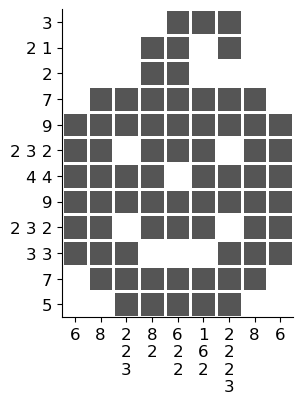

In [10]:
rows = [
    [3],
    [2,1],
    [2],
    [7],
    [9],
    [2, 3, 2],
    [4, 4],
    [9],
    [2, 3, 2],
    [3, 3],
    [7],
    [5]
]

cols = [
    [6],
    [8],
    [2, 2, 3],
    [8, 2],
    [6, 2, 2],
    [1, 6, 2],
    [2, 2, 2, 3],
    [8],
    [6]
]
pbn = NonogramSimpleSolver(rows, cols)
pbn.solve()
pbn.plot(figsize=(4, 4));

下の`solve_and_paint(fn, solver)`は、指定されたファイル内のノノグラムパズルを引数`solver`で解き、グラフを描画します。

[ノノグラムパズルのサイト](http://www.nonograms.org)  

In [11]:
import json

def solve_and_paint(fn, solver, figsize=(5, 5), font_size=12):
    with open(fn) as f:
        data = json.load(f)
    pbn = solver(data["rows"], data["cols"])
    pbn.solve()
    pbn.plot(figsize=figsize, font_size=font_size)

以下では、`nonogram02.json`ファイル内のパズルを解き、その計算時間を表示します。  

CPU times: total: 19.2 s
Wall time: 21.2 s


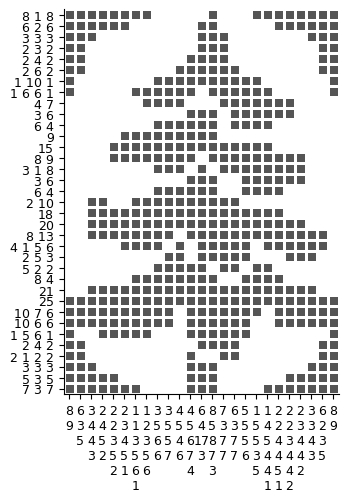

In [13]:
%time solve_and_paint("data/nonogram02.json", solver=NonogramSimpleSolver, font_size=9)

複雑なノノグラムパズルを解く際、`NonogramSimpleSolver`は長い時間を要します。これは、マス目の数が増えるにつれて、各行または各列の可能な解の数が急激に増加し、それに伴いCNF式の数も急増するためです。  

## 解法の高速化  

DNFをCNFに変換する方法には組み合わせ爆発の問題があります。マス目の数や数字が多い場合、それに対応する可能な解の数が急増します。例えば、数字が`[1, 2, 3, 2, 1]`で、マス目の数が30の場合、可能な解の数は26334通りにもなります。 

In [14]:
len(list(paint_numbers([1, 2, 3, 2, 1], 30)))

26334

この組み合わせ爆発の問題を解決するために、各数字に対応する最初の黒マスの位置を表すブール変数の集合を使用します。例えば、長さ10のマスに`[1, 2, 3]`という数字を配置する場合、数字`1`の開始位置は0、1、2の3通りのみです。  

以下の`create_position_variables()`は、長さ`count`のマスに`numbers`の数字を配置する際、それぞれの数字の開始位置を表すブール変数を作成します。新しいブール変数は`next(new_bool_variables)`によって生成され、その戻り値は`numbers`の各数字に対応する辞書のリストになります。辞書のキーはその数字の開始位置、値は対応するブール変数のインデックスです。例えば、インデックス9のブール変数が`True`の場合、数字3の開始位置は7であることを意味します。  

In [20]:
def start_pos(numbers, count):
    s = 0
    for i, n in enumerate(numbers):
        yield s
        s += n + 1

def end_pos(numbers, count):
    width = sum(numbers) + len(numbers) - 1
    start = count - width
    for pos in start_pos(numbers, count):
        yield start + pos
        
def create_position_variables(numbers, count, new_bool_variables):
    pos_variables = []
    for i, (a, b) in enumerate(zip(start_pos(numbers, count), end_pos(numbers, count))):
        pos_variables.append({j:next(new_bool_variables) for j in range(a, b + 1)})
    return pos_variables

numbers = [1, 2, 3]
count = 10
pos_variables = create_position_variables(numbers, count, itertools.count(1))
pos_variables

[{0: 1, 1: 2, 2: 3}, {2: 4, 3: 5, 4: 6}, {5: 7, 6: 8, 7: 9}]

以下では、`paint_numbers()`を使用して、10マスのパズルに`[1, 2, 3]`という数字が対応するすべての可能な解を出力します。これを`pos_variables`の内容と比較してみてください。  

In [21]:
for line in paint_numbers([1, 2, 3], 10):
    print([int(x > 0) for x in line])

[1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
[1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


次の`position_variables_constraint()`は、`create_position_variables()`で作成された位置変数が満たすべき制約を作成します。  

* 各数字の位置変数のうち、`True`になれるのは1つのみ。例えば、数字3に対応する位置変数のうち、インデックス7、8、9のブール変数のいずれか1つだけが`True`になる。  
* 連続する2つの数字`num1`, `num2`の位置`pos1`, `pos2`は、`pos2 > pos1 + num1`を満たす必要がある。例えば、インデックス5のブール変数が`True`なら、数字2の位置は3なので、数字3の位置は5より大きくなければならず、インデックス7のブール変数は`False`になる。  

以下の`position_variables_constraint()`は、これらの制約をCNF式として表現します。  

In [22]:
def only_one_true(variables):
    yield list(variables)
    for i, j in itertools.combinations(variables, 2):
        yield [-i, -j]
        
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)        

def position_variables_constraint(pos_variables, numbers):
    cnf = []
    # 各数字の位置変数のうち1つだけがTrue
    for i, pos_var in enumerate(pos_variables):
        cnf.extend(only_one_true(pos_var.values()))

    # 連続する数字の位置関係制約
    for i, (pos_var1, pos_var2) in enumerate(pairwise(pos_variables)):
        width = numbers[i] + 1
        for pos1, pos2 in itertools.product(pos_var1, pos_var2):
            if pos2 < pos1 + width:
                cnf.append([-pos_var1[pos1], -pos_var2[pos2]])
    return cnf

cnf = position_variables_constraint(pos_variables, numbers)
cnf

[[1, 2, 3],
 [-1, -2],
 [-1, -3],
 [-2, -3],
 [4, 5, 6],
 [-4, -5],
 [-4, -6],
 [-5, -6],
 [7, 8, 9],
 [-7, -8],
 [-7, -9],
 [-8, -9],
 [-2, -4],
 [-3, -4],
 [-3, -5],
 [-5, -7],
 [-6, -7],
 [-6, -8]]

作成した`cnf`式をPySATで解き、解をマスの塗り分け結果に変換します。例えば、最初の解`[1, -2, -3, 4, -5, -6, 7, -8, -9]`では、インデックス1、4、7のブール変数が`True`となり、それぞれの位置変数から数字1の開始位置は2、数字2は4、数字3は7であることが分かります。この情報を基に、各マスの状態を`[1, 0, 1, 1, 0, 1, 1, 1, 0, 0]`と求めることができます。この方法を使えば、各数字のすべての解を再帰的に計算するプログラムをCNF式で表現できます。  

In [25]:
sat = Solver()
sat.append_formula(cnf)

cell_map = {}
for n, pos_var in zip(numbers, pos_variables):
    for key, val in pos_var.items():
        cell_map[val] = (key, n)

for sol in sat.enum_models():
    true_vars = [loc for loc, v in enumerate(sol, 1) if v > 0]
    cells = [0] * 10
    for v in true_vars:
        s, n = cell_map[v]
        for j in range(s, s+n):
            cells[j] = 1
    print(sol, true_vars, cells)

[1, -2, -3, 4, -5, -6, 7, -8, -9] [1, 4, 7] [1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
[1, -2, -3, 4, -5, -6, -7, 8, -9] [1, 4, 8] [1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
[1, -2, -3, 4, -5, -6, -7, -8, 9] [1, 4, 9] [1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
[1, -2, -3, -4, -5, 6, -7, -8, 9] [1, 6, 9] [1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
[-1, -2, 3, -4, -5, 6, -7, -8, 9] [3, 6, 9] [0, 0, 1, 0, 1, 1, 0, 1, 1, 1]
[-1, 2, -3, -4, -5, 6, -7, -8, 9] [2, 6, 9] [0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
[-1, 2, -3, -4, 5, -6, -7, 8, -9] [2, 5, 8] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
[1, -2, -3, -4, 5, -6, -7, 8, -9] [1, 5, 8] [1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
[1, -2, -3, -4, 5, -6, -7, -8, 9] [1, 5, 9] [1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[-1, 2, -3, -4, 5, -6, -7, -8, 9] [2, 5, 9] [0, 1, 0, 1, 1, 0, 0, 1, 1, 1]


前述の方法で各行や列ごとの位置変数の制約を作成しましたが、行と列の関係を表す制約は各マスに対応するブール変数によって定義されます。そのため、さらにCNF式を追加し、位置変数の値をマスの塗り分け変数に変換する必要があります。各マスと塗り分けの開始位置の関係には次の4種類があります。以下の記法を使用します。 

- `num[i]`：`i`番目の数字  
- `pos[i]`：`i`番目の数字の開始位置  
- `cell[j]`：`j`番目のマス  

1. 最初の塗り開始位置より前のマスは塗られない：`cell[j] == 0, for all j < pos[0]`  
2. 最後の塗り終了位置より後のマスは塗られない：`cell[j] == 0, for all j >= pos[-1] + num[-1]`  
3. 塗り開始位置`pos[i]`から連続`num[i]`個のマスは塗られる：`cell[j] == 1, for all pos[i] <= j < pos[i] + num[i]`  
4. 連続する塗りの間のマスは塗られない：`cell[j] == 0, for all pos[i] + num[i] <= j < pos[i+1]`  

次の`cell_variables_constraint()`は、これら4種類の制約をCNF式に変換します。`pos_variables`は`create_position_variables()`で作成された位置変数リスト、`cell_variables`はマスの塗り分け状態を表すブール変数リストです。  

In [26]:
def cell_variables_constraint(pos_variables, cell_variables, numbers, count):
    cnf = []
    # cell[j] == 1 for all pos[i] <= j < pos[i] + num[i]
    for i, pos_var in enumerate(pos_variables):
        for pos, var in pos_var.items():
            for j in range(numbers[i]):
                cnf.append([-var, cell_variables[pos + j]])

    # cell[j] == 0, for all j < pos[0]
    for pos, var in pos_variables[0].items():
        for j in range(0, pos):
            cnf.append([-var, -cell_variables[j]])

    # cell[j] == 0, for all j >= pos[-1] + num[-1]
    for pos, var in pos_variables[-1].items():
        for j in range(pos + numbers[-1], count):
            cnf.append([-var, -cell_variables[j]])

    # cell[j] == 0 for all pos[i] + num[i] <= j < pos[i+1]
    for i, (pos_var1, pos_var2) in enumerate(pairwise(pos_variables)):
        for pos1, pos2 in itertools.product(pos_var1, pos_var2):
            if pos2 > pos1 + numbers[i]:
                for j in range(pos1 + numbers[i], pos2):
                    cnf.append([-pos_var1[pos1], -pos_var2[pos2], -cell_variables[j]])
    return cnf

最後に、10マスの塗り分け変数と各数字の位置変数を作成し、すべての制約条件を満たすCNF式を求めます。  

In [27]:
numbers = [1, 2, 3]
count = 10
cell_variables = list(range(1, count + 1))
pos_variables = create_position_variables(numbers, count, itertools.count(count + 1))
cnf = position_variables_constraint(pos_variables, numbers)
cnf += cell_variables_constraint(pos_variables, cell_variables, numbers, count)

これを解くことで、`cell_variables_constraint()`が作成したCNF式が自動的にマスを塗り分けられることが確認できます。 

In [28]:
sat = Solver()
sat.append_formula(cnf)
for sol in sat.enum_models():
    print([int(x > 0) for x in sol[:count]])

[1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
[1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
[1, 0, 0, 1, 1, 0, 1, 1, 1, 0]
[1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
[0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


以下の`NonogramFastSolver`クラスは、前述の関数を使ってノノグラムのCNF式を生成します。このクラスは`NonogramSimpleSolver`を継承し、`add_constraints()`メソッドのみを再定義しています。  

In [29]:
import numpy as np

class NonogramFastSolver(NonogramSimpleSolver):            
    def add_constraints(self, numbers, count, cell_variables):
        pos_variables = create_position_variables(numbers, count, self.new_vars)
        self.cnf.extend(position_variables_constraint(pos_variables, numbers))
        self.cnf.extend(cell_variables_constraint(pos_variables, cell_variables, numbers, count))

`NonogramFastSolver`はより大きなノノグラム問題を解くことができ、`nonogram02.json`のパズルでは、`NonogramSimpleSolver`の約50倍の速度で解を求められます。

CPU times: total: 328 ms
Wall time: 477 ms


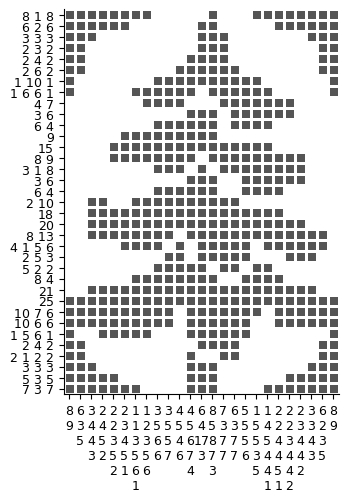

In [30]:
%time solve_and_paint("data/nonogram02.json", solver=NonogramFastSolver, font_size=9)

最後に、`NonogramFastSolver`を使用して、45×60の大規模なパズル`nonogram03.json`を解いてみましょう。

CPU times: total: 5.94 s
Wall time: 6.47 s


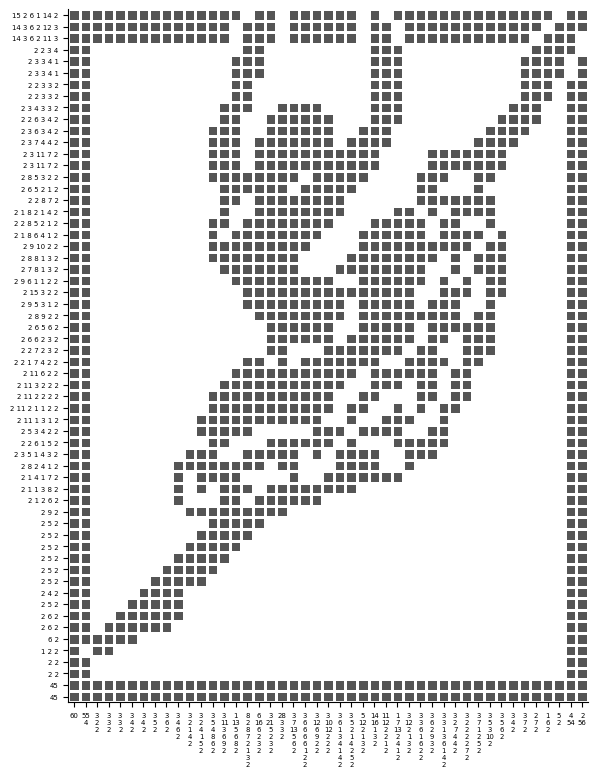

In [31]:
%time solve_and_paint("data/nonogram03.json", solver=NonogramFastSolver, figsize=(9, 9), font_size=5)